# Setup of a cell model with multi electrode simulation for local field potential recording

This notebook will demonstrate how to instantiate a cell model and evaluator that include local field potential (LFP) computation and its recording using a simulated multi electrode array (MEA).

First, let's start by installing the modules required to perform LFP simulation and recordings as well as compile the mechanisms:

In [1]:
!pip install LFPy
!pip install MEAutility
!nrnivmodl ../l5pc/mechanisms

/usr/bin/xcrun
/Users/damart/Desktop/BPO_LFPy/BluePyOpt/examples/l5pc_lfpy
-n Mod files:
-n  "../l5pc/mechanisms/CaDynamics_E2.mod"
-n  "../l5pc/mechanisms/Ca_HVA.mod"
-n  "../l5pc/mechanisms/Ca_LVAst.mod"
-n  "../l5pc/mechanisms/Ih.mod"
-n  "../l5pc/mechanisms/Im.mod"
-n  "../l5pc/mechanisms/K_Pst.mod"
-n  "../l5pc/mechanisms/K_Tst.mod"
-n  "../l5pc/mechanisms/NaTa_t.mod"
-n  "../l5pc/mechanisms/NaTs2_t.mod"
-n  "../l5pc/mechanisms/Nap_Et2.mod"
-n  "../l5pc/mechanisms/SK_E2.mod"
-n  "../l5pc/mechanisms/SKv3_1.mod"


Creating x86_64 directory for .o files.

COBJS=''
 -> Compiling mod_func.c
/usr/bin/clang -g  -O2   -I.   -I/Applications/NEURON/include  -I/usr/local/Cellar/open-mpi/4.0.5/include -fPIC -c mod_func.c -o mod_func.o
 -> NMODL ../../l5pc/mechanisms/CaDynamics_E2.mod
 -> NMODL ../../l5pc/mechanisms/Ca_HVA.mod
 -> NMODL ../../l5pc/mechanisms/Ca_LVAst.mod
(cd "../../l5pc/mechanisms"; MODLUNIT=/Applications/NEURON/share/nrn/lib/nrnunits.lib /Applications/NEURON/bin/nocmodl Ca_LV

Thread Safe
Thread Safe
Thread Safe
 -> Compiling Ca_HVA.c
 -> Compiling CaDynamics_E2.c
/usr/bin/clang -g  -O2   -I"../../l5pc/mechanisms" -I.   -I/Applications/NEURON/include  -I/usr/local/Cellar/open-mpi/4.0.5/include -fPIC -c Ca_HVA.c -o Ca_HVA.o
 -> Compiling Ca_LVAst.c
/usr/bin/clang -g  -O2   -I"../../l5pc/mechanisms" -I.   -I/Applications/NEURON/include  -I/usr/local/Cellar/open-mpi/4.0.5/include -fPIC -c CaDynamics_E2.c -o CaDynamics_E2.o
/usr/bin/clang -g  -O2   -I"../../l5pc/mechanisms" -I.   -I/Applications/NEURON/include  -I/usr/local/Cellar/open-mpi/4.0.5/include -fPIC -c Ca_LVAst.c -o Ca_LVAst.o
Ca_HVA.c:264:15: warning: equality comparison with extraneous parentheses [-Wparentheses-equality]
    if ( ( v  == - 27.0 ) ) {
           ~~~^~~~~~~~~
Ca_HVA.c:264:15: note: remove extraneous parentheses around the comparison to silence this warning
    if ( ( v  == - 27.0 ) ) {
         ~~   ^         ~~
Ca_HVA.c:264:15: note: use '=' to turn this equality comparison into an a

## Creating the neuron model and electrode

Let's plot the MEA that will be used to record LFP signal:

<AxesSubplot:>

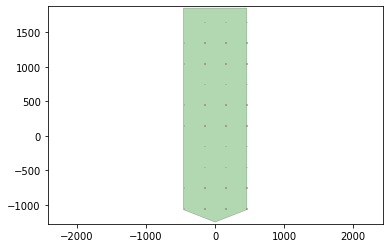

In [2]:
import l5pc_lfpy_model
import MEAutility as MEA

electrode = l5pc_lfpy_model.define_electrode()

MEA.plot_probe(electrode)

The models used in the present notebook is based on the L5PC cell presented in examples/l5pc.
However, the present cell model will also include an MEA. The resulting object will therefore be of type `LFPyCellModel` instead of `CellModel`:

In [3]:
import bluepyopt.ephys as ephys
l5pc_cell = l5pc_lfpy_model.create()
print(type(l5pc_cell))

<class 'bluepyopt.ephys.models.LFPyCellModel'>


## Creating the LFPy simulator and evaluator

To be able to compute the LFP, we need a simulator relying on FLPy:

In [6]:
lfpy_sim = ephys.simulators.LFPySimulator(cvode_active=True)

/Users/damart/Desktop/BPO_LFPy/BluePyOpt/bluepyopt/ephys/simulators.py:88: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON/lib/python/neuron, not disabling banner
  warnings.warn('Unable to find Neuron hoc shared library in %s, '


Then, as for the L5PC example, we create and evaluator from a cell model, a set of fitness protocol (here we only selected a single protocol) and a fitness calculator containig the efeature values the model is evaluated on: 

In [7]:
from l5pc_lfpy_evaluator import define_protocols, define_fitness_calculator

fitness_protocols = define_protocols()
fitness_calculator = define_fitness_calculator(fitness_protocols, feature_file="extra_features.json")

param_names = [
    param.name for param in l5pc_cell.params.values() if not param.frozen
]

evaluator = ephys.evaluators.CellEvaluator(
    cell_model=l5pc_cell,
    param_names=param_names,
    fitness_protocols=fitness_protocols,
    fitness_calculator=fitness_calculator,
    sim=lfpy_sim,
)

We can now run the protocol on the our model and plot the voltage recording at the soma.

Note that computing the LFP at every electrode of the MEA is computationally intensive. Therefore you can expect the evaluation of the model to be longer than usual.

In [8]:
from generate_extra_features import release_params
release_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=release_params)

/Users/damart/Desktop/BPO_LFPy/BluePyOpt/bluepyopt/ephys/responses.py:61: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response['voltage'] = pandas.Series(voltage)


Text(0.5, 1.0, 'Somatic voltage recording')

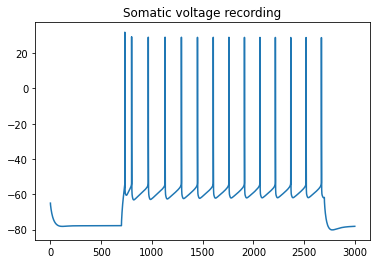

In [9]:
import matplotlib.pyplot as plt

plt.plot(release_responses['Step1.soma.v']['time'], 
         release_responses['Step1.soma.v']['voltage']
        )
plt.title("Somatic voltage recording")

We can also plot the LFP recording at every one of the electroe of the MEA:

/var/folders/x4/6vtsd6lx2fs_zpll9fgn6769mhvgb5/T/ipykernel_82221/2015095035.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


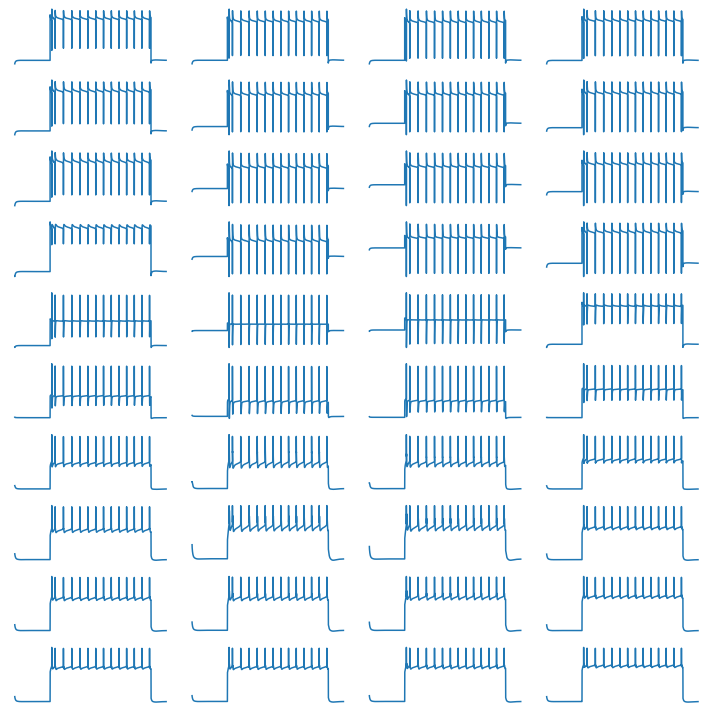

In [10]:
def plot_MEA_recordings(response, mea_dim=[10, 4]):
    fig, axes = plt.subplots(mea_dim[0], mea_dim[1], figsize=(10,10))
    for index, rec in enumerate(response['voltage']):
        n_row = index%10
        n_col = int(index/10)
        axes[n_row][n_col].plot(response['time'], rec)
        axes[n_row][n_col].get_xaxis().set_ticks([])
        axes[n_row][n_col].get_yaxis().set_ticks([])
        axes[n_row][n_col].spines['top'].set_visible(False)
        axes[n_row][n_col].spines['right'].set_visible(False)
        axes[n_row][n_col].spines['bottom'].set_visible(False)
        axes[n_row][n_col].spines['left'].set_visible(False)
    fig.tight_layout()
    fig.show()

plot_MEA_recordings(release_responses['Step1.MEA.v'])

The evaluator can then be used in the context of optimisation as is demonstrated in the notebook examples/l5pc/L5PC.ipynb.

For demonstration purppose, let's evaluate the model and plot the extracellular features for each of the electrodes:

In [11]:
efeature_values = evaluator.evaluate_with_dicts(param_dict=release_params, target='values')

/Users/damart/Desktop/BPO_LFPy/BluePyOpt/bluepyopt/ephys/responses.py:61: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response['voltage'] = pandas.Series(voltage)


/var/folders/x4/6vtsd6lx2fs_zpll9fgn6769mhvgb5/T/ipykernel_82221/639034954.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


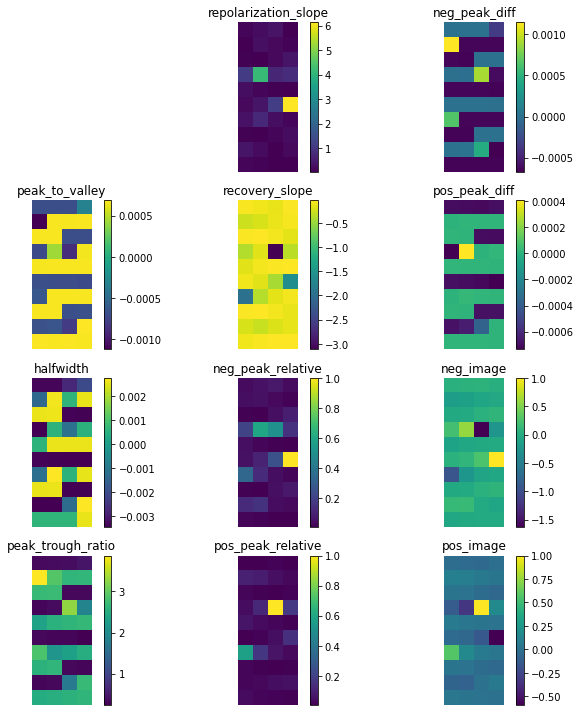

In [12]:
def plot_MEA_features(efeatures):
    
    rows = 4
    cols = 3

    fig, axes = plt.subplots(rows, cols, figsize=(10,10))
    index = 0
    for name, feat in efeatures.items():
        if "MEA" not in name:
            continue
        index += 1
        n_row = index%rows
        n_col = int(index/rows)
        im = axes[n_row][n_col].imshow(feat.reshape(10, 4))
        if im:
            fig.colorbar(im, ax=axes[n_row][n_col], location='right')
        axes[n_row][n_col].get_xaxis().set_ticks([])
        axes[n_row][n_col].get_yaxis().set_ticks([])
        axes[n_row][n_col].spines['top'].set_visible(False)
        axes[n_row][n_col].spines['right'].set_visible(False)
        axes[n_row][n_col].spines['bottom'].set_visible(False)
        axes[n_row][n_col].spines['left'].set_visible(False)
        axes[n_row][n_col].set_title(name.replace("Step1.MEA.", ""))
    axes[0][0].remove()
    fig.tight_layout()
    fig.show()


plot_MEA_features(efeature_values)